## Question 2 Part 2

### Done on google colab (that is why this is in a separate notebook)

### Imports

In [ ]:
import torch

### Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setting the working directory

In [ ]:
cd stylegan3

/content/stylegan3/stylegan3


In [ ]:
ls

avg_spectra.py   gen_images.py  metrics/                stylegan3/
calc_metrics.py  gen_video.py   out/                    torch_utils/
dataset_tool.py  gui_utils/     out.zip                 training/
dnnlib/          images/        __pycache__/            train.py
Dockerfile       latent/        README.md               visualizer.py
docs/            legacy.py      results/                viz/
environment.yml  LICENSE.txt    stylegan2-ada-pytorch/


In [ ]:
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Settting up the device to GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Plotting the images generated in the output directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

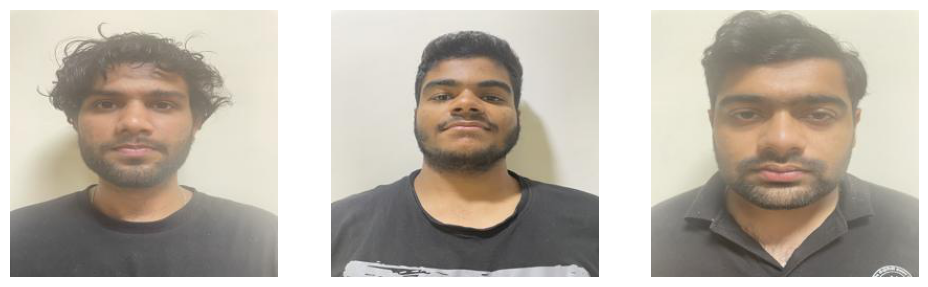

In [ ]:
images = []
for filename in os.listdir('./images'):
    images.append(mpimg.imread('./images/' + filename))

plt.figure(figsize=(20, 20))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

In [ ]:
!pip install dnnlib-util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install legacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Necessary imports

In [ ]:
import sys
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import IPython.display
import dnnlib
import legacy

### Loading the model StyleGAN3 (256x256 images)

In [ ]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result


URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl"

print(f'Loading networks from "{URL}"...')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl"...
(1, 512)


### Function for generating images through latent space 

In [ ]:
def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', 
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

### Cloning StyleGan2 repo for projection function using StyleGAN2 for creating latent vectors of images

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (57/57), done.


### Latent vector for the 1st image

In [ ]:
!python3 stylegan2-ada-pytorch/projector.py --outdir=latent/0 --target=images/0.jpg --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.74 loss 24567.40
step    2/1000: dist 0.73 loss 27640.71
step    3/1000: dist 0.74 loss 27166.85
step    4/1000: dist 0.69 loss 26253.49
step    5/1000: dist 0.70 loss 24957.31
step    6/1000: dist 0.77 loss 23352.31
step    7/1000: dist 0.72 loss 21510.88
step    8/1000: dist 0.69 loss 19486.97
step    9/1000: dist 0.67 loss 17341.61
step   10/1000: dist 0.67 loss 15140.45
step   11/1000: dist 0.68 loss 12947.

### Latent vector for 2nd image

In [ ]:
!python3 stylegan2-ada-pytorch/projector.py --outdir=latent/1 --target=images/1.jpg --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.69 loss 24567.35
step    2/1000: dist 0.69 loss 27640.66
step    3/1000: dist 0.72 loss 27166.84
step    4/1000: dist 0.69 loss 26253.48
step    5/1000: dist 0.70 loss 24957.31
step    6/1000: dist 0.76 loss 23352.30
step    7/1000: dist 0.72 loss 21510.88
step    8/1000: dist 0.67 loss 19486.95
step    9/1000: dist 0.66 loss 17341.60
step   10/1000: dist 0.65 loss 15140.43
step   11/1000: dist 0.67 loss 12947.

### Latent vector for 3rd image

In [ ]:
!python3 stylegan2-ada-pytorch/projector.py --outdir=latent/2 --target=images/2.jpg --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %105 : int = prim::profile_ivalue(%103)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.65 loss 24567.31
step    2/1000: dist 0.64 loss 27640.62
step    3/1000: dist 0.68 loss 27166.80
step    4/1000: dist 0.65 loss 26253.45
step    5/1000: dist 0.66 loss 24957.28
step    6/1000: dist 0.72 loss 23352.26
step    7/1000: dist 0.69 loss 21510.84
step    8/1000: dist 0.62 loss 19486.90
step    9/1000: dist 0.63 loss 17341.57
step   10/1000: dist 0.61 loss 15140.39
step   11/1000: dist 0.63 loss 12947.

### Loading the latent vectors created

In [ ]:
latent1 = np.load('./latent/0/projected_w.npz')['w']
latent2 = np.load('./latent/1/projected_w.npz')['w']
latent3 = np.load('./latent/2/projected_w.npz')['w']

### Reshaping the latent vectors

In [ ]:
l1 = latent1.reshape(18, 512)
l2 = latent2.reshape(18, 512)
l3 = latent3.reshape(18, 512)

### Creating frames for the video of interpolation between two images

In [ ]:
SEEDS = [6624,6618,6616] 
STEPS = 100

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = l1
  v2 = l2
  v3 = l3

  diff = v3 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1

Seed 6624:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 6618:   0%|          | 0/100 [00:00<?, ?it/s]

### Generating a video of interpolations between two images

In [ ]:
# Link the images into a video.
!ffmpeg -r 30 -i /content/stylegan3/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e